In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math
from LatLongUTMconversion import LLtoUTM, UTMtoLL
import mission_plan_v2 as mp

In [2]:
# Function definitions

def dist_2points(x1, y1, x2, y2):
    distance = math.sqrt(((x1-x2)**2)+((y1-y2)**2))
    return distance

def get_offset_coords(x, y, slope, dist):
    new_x = x + dist*math.sqrt( 1/(1+math.pow(slope,2)) )
    new_y = y + slope*dist*math.sqrt( 1/(1+math.pow(slope,2)) )
    return(new_x,new_y)

def dist_2points_ll(lat1, lon1, lat2, lon2):
    (zone,x1,y1)=LLtoUTM(23, lat1, lon1)
    (zone,x2,y2)=LLtoUTM(23, lat2, lon2)
    distance = math.sqrt(((x1-x2)**2)+((y1-y2)**2))
    return distance

In [3]:
#Original White line measurements in [lattitude, longitude]
lane1_sp = [41.3907167,-73.9533818]
lane1_ep = [41.3915655,-73.9529646]

In [4]:
# Two points difference
check_pt1 = [lane1_sp[0],lane1_sp[1]]
check_pt2 = [41.3906929, -73.9532965]

print("The distance between two points is %8.4f m" % (dist_2points_ll(check_pt1[0],check_pt1[1],check_pt2[0],check_pt2[1])))

The distance between two points is   7.6058 m


In [5]:
# Convert line coords to UTM and show distance
(zone,easting,northing)=LLtoUTM(23, lane1_sp[0], lane1_sp[1])
lane1_utm_sp = (easting,northing)

(zone,easting,northing)=LLtoUTM(23, lane1_ep[0], lane1_ep[1])
lane1_utm_ep = (easting,northing)

print("Zone: " + str(zone))
print("Line start point: " + str(lane1_utm_sp))
print("Line  end  point: " + str(lane1_utm_ep))
dist = dist_2points(lane1_utm_sp[0], lane1_utm_sp[1], lane1_utm_ep[0], lane1_utm_ep[1]) 
print("Distance between 2 points is: %8.2f m" % (dist))

Zone: 18T
Line start point: (587500.9688644903, 4582660.24429328)
Line  end  point: (587534.7100171925, 4582754.898983267)
Distance between 2 points is:   100.49 m


In [6]:
# Compute slope and perpendicular slope
lane1_slope = (lane1_utm_sp[1] - lane1_utm_ep[1]) / (lane1_utm_sp[0] - lane1_utm_ep[0])
line_slope = -1/lane1_slope
print("The slope of the line is:   %8.4f \nThe perpendicular slope is: %8.4f" % (lane1_slope, -1/lane1_slope))
yaw = math.atan(lane1_slope)
print("Yaw in degrees: %8.2f deg." % (yaw*180/math.pi))

The slope of the line is:     2.8053 
The perpendicular slope is:  -0.3565
Yaw in degrees:    70.38 deg.


In [7]:
# Mission parameters
cam_mount_angle = 60    # in degrees
cam_fov = 40.0         # in degrees
speed = 3.5             # in m/s

HPC = 5.0               # in meters
LPC = 10.0              # in meters

In [8]:
# Scanning distance d_scan (d_far - d_near)
angle_far = (90 - cam_mount_angle + cam_fov/2)     # in degrees
angle_near = (90 - cam_mount_angle - cam_fov/2)    # in degrees
angle_far_rad = (angle_far*math.pi/180)             # in radian
angle_near_rad = (angle_near*math.pi/180)           # in radian
# d_scan = altitude * (math.tan(angle_far_rad) - math.tan(angle_near_rad))

# Input: d_scan requited total scanning distance 
d_scan = HPC + LPC

# Output: alt_req (for required d_s with gobi)
alt_req = d_scan / (math.tan(angle_far_rad) - math.tan(angle_near_rad))

print("HPC: %2.2f m , LPC: %2.2f m" % (HPC,LPC))
print("The required altitude is: %5.3f m" % (alt_req))

# Compute offset from the line
d_offset = HPC + alt_req * math.tan(angle_near_rad) # Offset is HPC + d_near 

print("The offset distance is: %5.3f m (Cam mount: %4.2f deg., FOV: %4.2f deg.)" % (d_offset,cam_mount_angle, cam_fov))

HPC: 5.00 m , LPC: 10.00 m
The required altitude is: 14.772 m
The offset distance is: 7.605 m (Cam mount: 60.00 deg., FOV: 40.00 deg.)


In [9]:
pnt_1 = get_offset_coords(lane1_utm_sp[0],lane1_utm_sp[1],line_slope,d_offset)
pnt_2 = get_offset_coords(lane1_utm_ep[0],lane1_utm_ep[1],line_slope,d_offset)
pnt_3 = get_offset_coords(lane1_utm_ep[0],lane1_utm_ep[1],line_slope,(-1*d_offset))
pnt_4 = get_offset_coords(lane1_utm_sp[0],lane1_utm_sp[1],line_slope,(-1*d_offset))

ll_pt1 = UTMtoLL(23, pnt_1[1], pnt_1[0], '18T')
ll_pt2 = UTMtoLL(23, pnt_2[1], pnt_2[0], '18T')
ll_pt3 = UTMtoLL(23, pnt_3[1], pnt_3[0], '18T')
ll_pt4 = UTMtoLL(23, pnt_4[1], pnt_4[0], '18T')

print("wp1:" + str(ll_pt1))
print("wp2:" + str(ll_pt2))
print("wp3:" + str(ll_pt3))
print("wp4:" + str(ll_pt4))
print(lane1_utm_sp)


wp1:(41.3906929, -73.9532965)
wp2:(41.3915417, -73.9528793)
wp3:(41.3915893, -73.9530499)
wp4:(41.3907405, -73.9534671)
(587500.9688644903, 4582660.24429328)


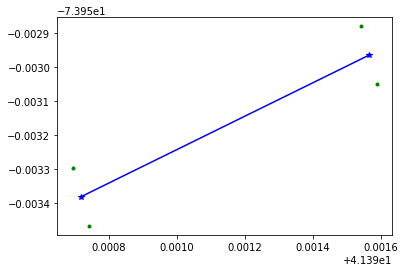

In [10]:
plt.figure(1)
#plt.gca().add_line(mlines.Line2D([lane1_sp[0],lane1_sp[1]], [lane1_ep[0],lane1_ep[1]]))
plt.plot([lane1_sp[0],lane1_ep[0]], [lane1_sp[1],lane1_ep[1]], marker='*',color='blue')
plt.plot(ll_pt1[0],ll_pt1[1], 'g.')
plt.plot(ll_pt2[0],ll_pt2[1], 'g.')
plt.plot(ll_pt3[0],ll_pt3[1], 'g.')
plt.plot(ll_pt4[0],ll_pt4[1], 'g.')

plt.axis('equal');

In [11]:
yaw = 289

# Waypoints + Lane1 starting point
wp1 = [ll_pt1[0],ll_pt1[1],alt_req,3]
wp2 = [ll_pt2[0],ll_pt2[1],alt_req,2] 
wp3 = [ll_pt3[0],ll_pt3[1],alt_req,3] 
wp4 = [ll_pt3[0],ll_pt3[1],alt_req,5] 
wp5 = [ll_pt4[0],ll_pt4[1],alt_req,0]

waypoints = [wp1,wp2,wp3,wp4,wp5]
sp_lane1 = [lane1_sp[0],lane1_sp[1],alt_req,0]
# TODO_JH: Update RTK (Lat,Lon) DATA
# RTK points
rtk_pt1 = [41.390651194,-73.953278861,alt_req,3]
rtk_pt2 = [41.390823944,-73.953626667,alt_req,3]
rtk_pt3 = [41.391267139,-73.953483611,alt_req,3]
rtk_pt4 = [41.390525194,-73.953372389,alt_req,3]

# 115 is MAV_CMD_CONDITION_YAW: [115, rot_angle] - If (rot_angle) is negative, then it rotates CCW.
# 178 is MAV_CMD_DO_CHANGE_SPEED: [178, speed]
# 16 is MAV_CMD_NAV_WAYPOINT
mission_input = [rtk_pt1,[115,yaw],wp1,[178,speed],wp2,wp3,[115,-180],wp4,wp5,sp_lane1]

with open('bhg_flight.plan_v2', 'w') as f:
    plan = mp.make_plan(mission_input,speed,yaw)
    #print(plan)
    f.write(plan)
print('Waypoints are \n'+str(wp1)+'\n'+str(wp2)+'\n'+str(wp3)+'\n'+str(wp4)+'\n'+str(wp5))
print("\n++ New flight plan is generated!!")

Waypoints are 
[41.3906929, -73.9532965, 14.772116295183123, 3]
[41.3915417, -73.9528793, 14.772116295183123, 2]
[41.3915893, -73.9530499, 14.772116295183123, 3]
[41.3915893, -73.9530499, 14.772116295183123, 5]
[41.3907405, -73.9534671, 14.772116295183123, 0]

++ New flight plan is generated!!
